In [24]:
import warnings
warnings.filterwarnings('ignore')

Portfolio selection
-------------------

### Introduction

Portfolio selection theory [[1]](#refer-anchor-1) plays a significant role in modern asset management. Its main task is to decide the investment weights $\mathrm{w}\in\mathbb{R}^N$ of $N$ assets subject the budget constraint $\mathbf{1^{\top}w}=1$. To formulate the portfolio selection problem as an optimization problem, we denote $\mathbf{\mu}\in\mathbb{R}^N$ as the mean vector and $\mathbf{\Sigma}\in\mathbb{R}^{N\times N}$ as the covariance matrix of these $N$ assets. Besides, we denote $\lambda>0$ as a penalty hyper-parameter to balance the variance and return of a portfolio.

### China securities index data analysis

#### Description

Before constructing the portfolios, we introduce the data simply. In this example, we collect adjusted daily return of the composite stocks of China securities index (CSI) 500 from 2020-01-01 to 2021-12-31. After dropping those stocks with missing data ratio grater than 0.05, we hold daily returns of 460 stocks spanning 486 trading days.

We then split the full data into the training data $\mathbf{X}_{\mathrm{train}}\in\mathbb{R}^{361\times 460}$ and the test data $\mathbf{X}_{\mathrm{test}}\in\mathbb{R}^{125\times 460}$. All optimization problems are solved using $\mathbf{X}_{\mathrm{train}}$ only and their performance are measured using $\mathbf{X}_{\mathrm{test}}$.

In [25]:
import pandas as pd
df = pd.read_csv('./data/csi500-2020-2021.csv', encoding='gbk')
cols = df.columns[df.isnull().sum() <= (0.05 * len(df))]
df = df[cols]
df = df.fillna(0)
df.iloc[:, 0] = pd.to_datetime(df.iloc[:, 0])
X_train = df[df.iloc[:, 0] < pd.to_datetime('2021-07-01')].iloc[:, 1:].values / 100
X_test = df[df.iloc[:, 0] >= pd.to_datetime('2021-07-01')].iloc[:, 1:].values / 100

print('Train data shape: ', X_train.shape)
print('Test data shape: ', X_test.shape)
T, N = X_test.shape

# truncate the outliers
X_train[X_train >= 0.1] = 0.1
X_train[X_train < -0.1] = -0.1
X_test[X_test >= 0.1] = 0.1
X_test[X_test < -0.1] = -0.1

Train data shape:  (361, 460)
Test data shape:  (125, 460)


### Five famous portfolios

Here, we introduce five famous portfolios and we would like to assess the performance of these portfolios on the CSI dataset. We first give their definition coupled with their mathematical formulation. 

1. Equally weighted portfolio $\mathbf{w}^{ew}$ allocates equal weight to each asset such that: 
    $$\mathbf{w}^{ew}:=(1/N, 1/N, \cdots, 1/N).$$

2. Global minimum variance portfolio $\mathbf{w}^{gmv}$ minimizes the variance of the portfolio such that: 
    $$\mathbf{w}^{gmv}:=\arg\min \mathbf{w}^{\top}\mathbf{\Sigma w} \text{ s.t. } \mathbf{1^{\top}w}=1.$$

3. Mean variance portfolio $\mathbf{w}^{mv}$ minimizes the return-adjusted variance of the portfolio such that: 
    $$\mathbf{w}^{mv}:=\arg\min \mathbf{w}^{\top}\mathbf{\Sigma w}-\lambda\mathbf{w^{\top}\mu} \text{ s.t. } \mathbf{1^{\top}w}=1.$$

4. Sparse global minimum variance portfolio $\mathbf{w}^{sgmv}$ minimizes the variance of the portfolio with cardinality constraint such that: 
    $$\mathbf{w}^{sgmv}:=\arg\min \mathbf{w}^{\top}\mathbf{\Sigma w} \text{ s.t. } \mathbf{1^{\top}w}=1, \|\mathbf{w}\|_0\leq k.$$

5. Sparse mean variance portfolio $\mathbf{w}^{smv}$ minimizes the return-adjusted variance of the portfolio with cardinality constraint such that: 
    $$\mathbf{w}^{smv}:=\arg\min \mathbf{w}^{\top}\mathbf{\Sigma w}-\lambda\mathbf{w^{\top}\mu} \text{ s.t. } \mathbf{1^{\top}w}=1, \|\mathbf{w}\|_0\leq k.$$

### Estimation procedures

#### GMV and MV portfolios

The optimization problems GMV and MV portfolios have analytic solutions:
$$\mathbf{w}^{gmv}=\frac{\mathbf{\Sigma}^{-1}\mathbf{1}}{\mathbf{1}^{\top}\mathbf{\Sigma}^{-1}\mathbf{1}}, \qquad \mathbf{w}^{mv}=\lambda\mathbf{\Sigma}^{-1}\mathbf{\mu} + \frac{1-\lambda\mathbf{1}^{\top}\mathbf{\Sigma}^{-1}\mathbf{\mu}}{\mathbf{1}^{\top}\mathbf{\Sigma}^{-1}\mathbf{1}}\mathbf{\Sigma}^{-1}\mathbf{1}.$$

However, the parameters $\mathbf{\mu}$ and $\mathbf{\Sigma}$ are unknown in practice. Thus, we need to estimate them from historical return data $\mathbf{X}^{T\times N}$ where $T$ is the sample size. As for the mean vector, we replace it with a sample mean $$\widehat{\mathbf{\mu}}=\frac{1}{N}\mathbf{X^{\top}1}.$$

In terms of $\mathbf{\Sigma}$, traditional sample covariance is forbidden for its bad practical performance (or irreversibility) in the high-dimensional case (i.e., $N \gg T$). A common alternative is to plug in a better estimator, such as the Ledoit-Wolf [[2]](#refer-anchor-2) covariance estimator used in the following. And thus, we plug the Ledoit-Wolf covariance estimator into problems 2 and 3.

#### GMV and MV portfolios

For the sparse optimization problems in 4 and 5, we can solve them using ``skscope``. Specifically, we can reformulate the SGMV portfolio as:
$$\arg\min \mathbf{w}^{\top}\mathbf{\Sigma w} \text{ s.t. } \mathbf{1^{\top}w}=1, \|\mathbf{w}\|_0\leq k  \Longrightarrow \arg\min \frac{\mathbf{w'}^{\top}\mathbf{\Sigma w'}}{\|w'\|^2} \text{ s.t. }, \|\mathbf{w'}\|_0\leq k,$$
then we expect $\mathbf{w'} / \|\mathbf{w'}\|$ is equivalent to the SGMV portfolio $\mathbf{w}$. Upon on this reformulation, we can solve SGMV by `skscope`. Notably, the re-formulation strategy can be similarly apply on the SMV portfolio. 
Like GMV and MV portfolios, $\mathbf{\mu}$ and $\mathbf{\Sigma}$ shall be determined by data; consequently, we employ sample mean and sample covariance to replace $\mathbf{\mu}$ and $\mathbf{\Sigma}$ in problems 4 and 5.  

### Implementation

Then, the aforementioned five portfolios are constructed as follows.

#### EW, GMV, MV portfolios
Here, we set the hyper-parameter in MV as $\lambda=0.001$.

In [26]:
import numpy as np
from sklearn.covariance import LedoitWolf

# equal weighted portfolio
w_ew = np.ones(N) / N

mu_train = np.mean(X_train, axis=0)
Sigma_train = LedoitWolf().fit(X_train).covariance_

# global variance portfolio
w_gmv = np.linalg.inv(Sigma_train) @ np.ones(N)
w_gmv = w_gmv / w_gmv.sum()

# mean variance portfolio
lambda_ = 0.001
w_mv_1 = np.linalg.inv(Sigma_train) @ mu_train
w_mv_2 = np.linalg.inv(Sigma_train) @ np.ones(N)
w_mv = w_mv_1 * lambda_ + w_mv_2 * (1 - lambda_ * np.ones(N) @ w_mv_1) / (np.ones(N) @ w_mv_2)

#### SGMV and SMV portfolios

The following functions ``sgmv`` and ``smv`` solve problems 4 and 5 separately and we use the following 2 tricks mentioned before:

- we bypass the linear constraint $\mathbf{1^{\top}w}=1$ by directly optimizing its normalized counterpart ``w / jnp.sum(w)``,

- the ``init_params`` is set with random numbers rather than all zeros to avoid division by zero.

The implementations are presented below. 

In [27]:
import jax.numpy as jnp
from skscope import ScopeSolver

rng = np.random.default_rng(0)
init_params = rng.standard_normal(N) 

def sgmv(X, k):
    '''
    sparse global variance portfolio
    '''
    T, N = X.shape
    Sigma = np.cov(X.T)

    def custom_objective(params):
        params = params / jnp.sum(params)
        var = params @ Sigma @ params
        return var
    
    solver = ScopeSolver(N, k)
    params = solver.solve(custom_objective, init_params=init_params)
    return params / params.sum()

def smv(X, lambda_, k):
    '''
    sparse mean variance portfolio
    '''
    T, N = X.shape
    mu = np.mean(X, axis=0)
    Sigma = np.cov(X.T)

    def custom_objective(params):
        params = params / jnp.sum(params)
        var = params @ Sigma @ params - lambda_ * mu @ params
        return var
    
    solver = ScopeSolver(N, k)
    params = solver.solve(custom_objective, init_params=init_params)
    return params / params.sum()

Without the loss of generality, we set the sparsity parameter $k=30$ on the CSI data.

In [28]:
k = 30
w_sgmv = sgmv(X_train, k=k)
w_smv = smv(X_train, lambda_=lambda_, k=k)

### Results on CSI data

Cumulated returns are calculated and plotted in the following figure.

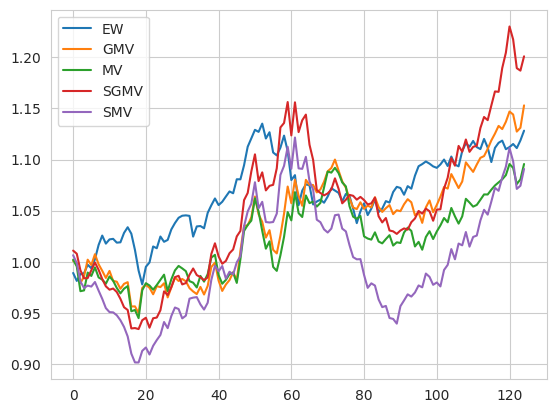

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

ret_ew = np.cumprod(1 + X_test @ w_ew)
ret_gmv = np.cumprod(1 + X_test @ w_gmv)
ret_mv = np.cumprod(1 + X_test @ w_mv)
ret_sgmv = np.cumprod(1 + X_test @ w_sgmv)
ret_smv = np.cumprod(1 + X_test @ w_smv)

plt.plot(ret_ew, label='EW')
plt.plot(ret_gmv, label='GMV')
plt.plot(ret_mv, label='MV')
plt.plot(ret_sgmv, label='SGMV')
plt.plot(ret_smv, label='SMV')

plt.legend()
plt.show()

Moreover, we calculate the Sharpe ratios [[3]](#refer-anchor-3) of these $5$ portfolios and the results validate the efficiency of our proposed portfolios $\mathbf{w}^{sgmv}$ and $\mathbf{w}^{smv}$.

In [30]:
sr_ew = np.mean(X_test @ w_ew) / np.std(X_test @ w_ew)
sr_gmv = np.mean(X_test @ w_gmv) / np.std(X_test @ w_gmv)
sr_mv = np.mean(X_test @ w_mv) / np.std(X_test @ w_mv)
sr_sgmv = np.mean(X_test @ w_sgmv) / np.std(X_test @ w_sgmv)
sr_smv = np.mean(X_test @ w_smv) / np.std(X_test @ w_smv)

print('Shapre ratio of EW: ', sr_ew.round(3))
print('Shapre ratio of GMV: ', sr_gmv.round(3))
print('Shapre ratio of MV: ', sr_mv.round(3))
print('Shapre ratio of SGMV: ', sr_sgmv.round(3))
print('Shapre ratio of SMV: ', sr_smv.round(3))

Shapre ratio of EW:  0.114
Shapre ratio of GMV:  0.115
Shapre ratio of MV:  0.073
Shapre ratio of SGMV:  0.133
Shapre ratio of SMV:  0.065


From the above results, we see that:

- the equal weight (EW) portfolio is still efficient compared to GMV and MV, though it ignores the information of mean and covariance;

- the sparse global minimum variance (SGMV) portfolio obtains the largest Sharpe ratio;
  
- GMV-type portfolio performs better than MV-type portfolio and a possible reason is that estimating the mean is much harder than covariance in the context of finance;
  
- skscope cooperate with GMV-type portfolio better than MV-type portfolio.


### Reference

<div id="refer-anchor-1"></div>

- [1] Markowitz, H. (1952) Portfolio Selection. The Journal of Finance, 7, 77-91.

<div id="refer-anchor-2"></div>

- [2] Ledoit O, Wolf M. A well-conditioned estimator for large-dimensional covariance matrices[J]. Journal of multivariate analysis, 2004, 88(2): 365-411.

<div id="refer-anchor-3"></div>

- [3] Sharpe W F. The sharpe ratio[J]. Streetwise–the Best of the Journal of Portfolio Management, 1998, 3: 169-185.